In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import math
import seaborn as sns
from scipy.stats import skew, kurtosis, norm
from sklearn.metrics import confusion_matrix, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector as SFS
import time
from sklearn.preprocessing import scale
from typing import Union

In [ ]:
#Read dataset
df_i = pd.read_csv("high_diamond_ranked_10min.csv")
df_i.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [ ]:
#combine variables
df = pd.DataFrame({
    "gameId":df_i["gameId"], 
    "blueWins": df_i["blueWins"],
    "FirstBlood": df_i["blueFirstBlood"],
    "WardsPlacedDiff": df_i["blueWardsPlaced"] - df_i["redWardsPlaced"],
    "WardsDestroyedDiff": df_i["blueWardsDestroyed"] - df_i["redWardsDestroyed"],
    "KillsDiff": df_i["blueKills"] - df_i["redKills"],
    "AssistsDiff": df_i["blueAssists"] - df_i["redAssists"],
    "Dragons": df_i["blueDragons"] - df_i["redDragons"],
    "Heralds": df_i["blueHeralds"] - df_i["redHeralds"],
    "TowersDestroyedDiff": df_i["blueTowersDestroyed"] - df_i["redTowersDestroyed"],
    "GoldDiff": df_i["blueTotalGold"] - df_i["redTotalGold"],
    "AvgLevelDiff": df_i["blueAvgLevel"] - df_i["redAvgLevel"],
    "ExperienceDiff": df_i["blueTotalExperience"] - df_i["redTotalExperience"],
    "CSdiff": df_i["blueTotalMinionsKilled"] - df_i["redTotalMinionsKilled"],
    "JungleMinionsKilledDiff": df_i["blueTotalJungleMinionsKilled"] - df_i["redTotalJungleMinionsKilled"]
})

#@ Logistic Regresson


In [ ]:
features = ['FirstBlood',
  'Dragons',
  'Heralds',
  'WardsPlacedDiff',
  'WardsDestroyedDiff',
  'KillsDiff',
  'AssistsDiff',
  'TowersDestroyedDiff',
  'GoldDiff',
  'AvgLevelDiff',
  'ExperienceDiff',
  'CSdiff',
  'JungleMinionsKilledDiff']

In [ ]:
#check for ratios
def ratio_cal(features, data):
  for name in features:
    print(f'{name}:', end=" ")
    for key in Counter(data[name]):
      print(f'{key} ({round(Counter(data[name])[key] *100 / len(data.index),2)}%)', end=', ')
    print('\n')

In [ ]:
#catagorical variables
cat_features = ["FirstBlood", "Dragons", "Heralds"]
ratio_cal(cat_features, df)

FirstBlood: 1 (50.48%), 0 (49.52%), 

Dragons: 0 (22.49%), -1 (41.31%), 1 (36.2%), 

Heralds: 0 (65.2%), -1 (16.0%), 1 (18.8%), 



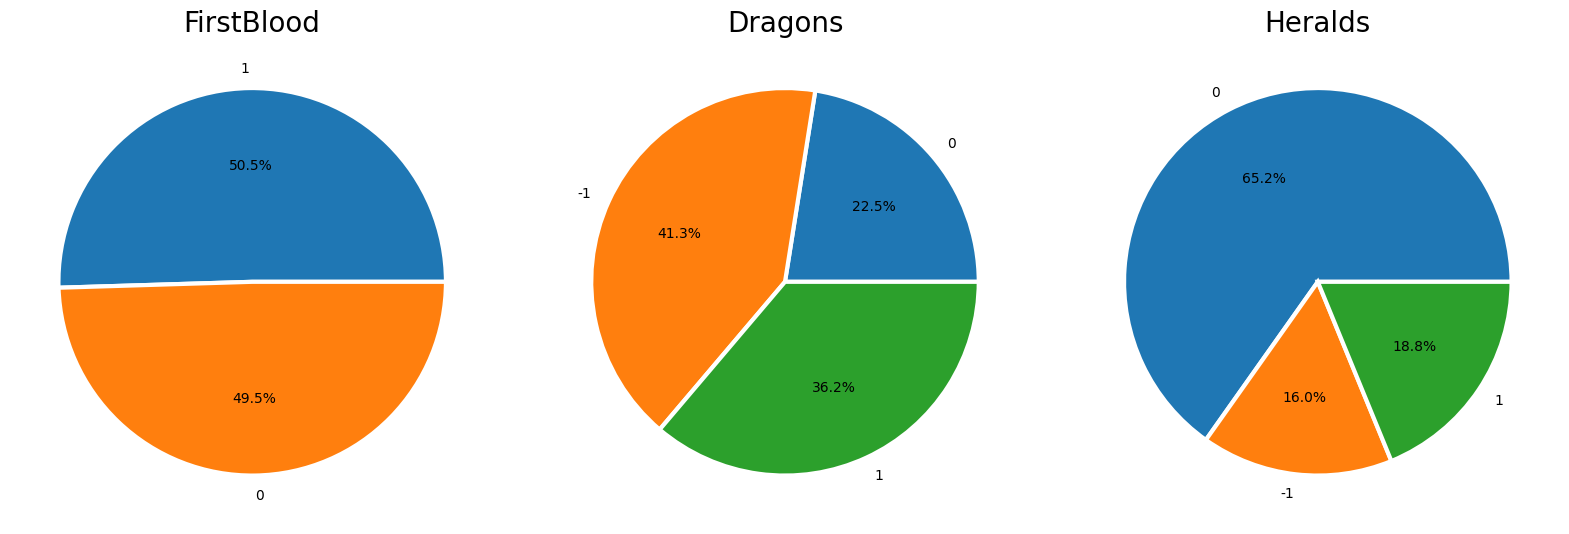

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,40))
i=0
for _ in cat_features:
  ax[i].pie([round(Counter(df[_])[key] *100 / 25341,2) for key in  Counter(df[_])], labels=[key for key in  Counter(df[_])], autopct='%.1f%%',wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
  ax[i].set_title(_, fontsize=20)
  i += 1
plt.subplots_adjust(wspace=0.1, hspace=0.0)
plt.show()

In [ ]:
#continuous variables
cont_features = ["WardsPlacedDiff", "WardsDestroyedDiff", "KillsDiff", "AssistsDiff",
                 "TowersDestroyedDiff", "GoldDiff", "AvgLevelDiff", "ExperienceDiff", "CSdiff", "JungleMinionsKilledDiff"]

#calculate the statistics
stats = pd.DataFrame(index=[var for var in cont_features])
stats["mean"] = [round(np.mean(df[var]),2) for var in cont_features]
stats["std"] = [round(np.std(df[var]),2) for var in cont_features]
stats["(min,max)"] = [f'({round(min(df[var]),2)},{round(max(df[var]),2)})' for var in cont_features]
stats["kurtosis"] = [round(kurtosis(df[var]),2) for var in cont_features]
stats["skewness"] = [round(skew(df[var]),2) for var in cont_features]

display(stats)

,mean,std,"(min,max)",kurtosis,skewness
WardsPlacedDiff,-0.08,25.96,"(-260,234)",13.46,-0.27
WardsDestroyedDiff,0.10,2.85,"(-23,23)",11.97,-0.00
KillsDiff,0.05,4.20,"(-17,16)",0.10,0.02
AssistsDiff,-0.02,5.77,"(-25,23)",0.33,-0.02
TowersDestroyedDiff,0.01,0.32,"(-2,4)",18.51,0.79
GoldDiff,14.41,2453.23,"(-10830,11467)",0.30,0.03
AvgLevelDiff,-0.01,0.48,"(-2.6,2.4)",0.58,0.01
ExperienceDiff,-33.62,1920.27,"(-9333,8348)",0.36,0.02
CSdiff,-0.65,30.94,"(-120,127)",0.21,0.02
JungleMinionsKilledDiff,-0.80,14.27,"(-72,64)",0.45,-0.11


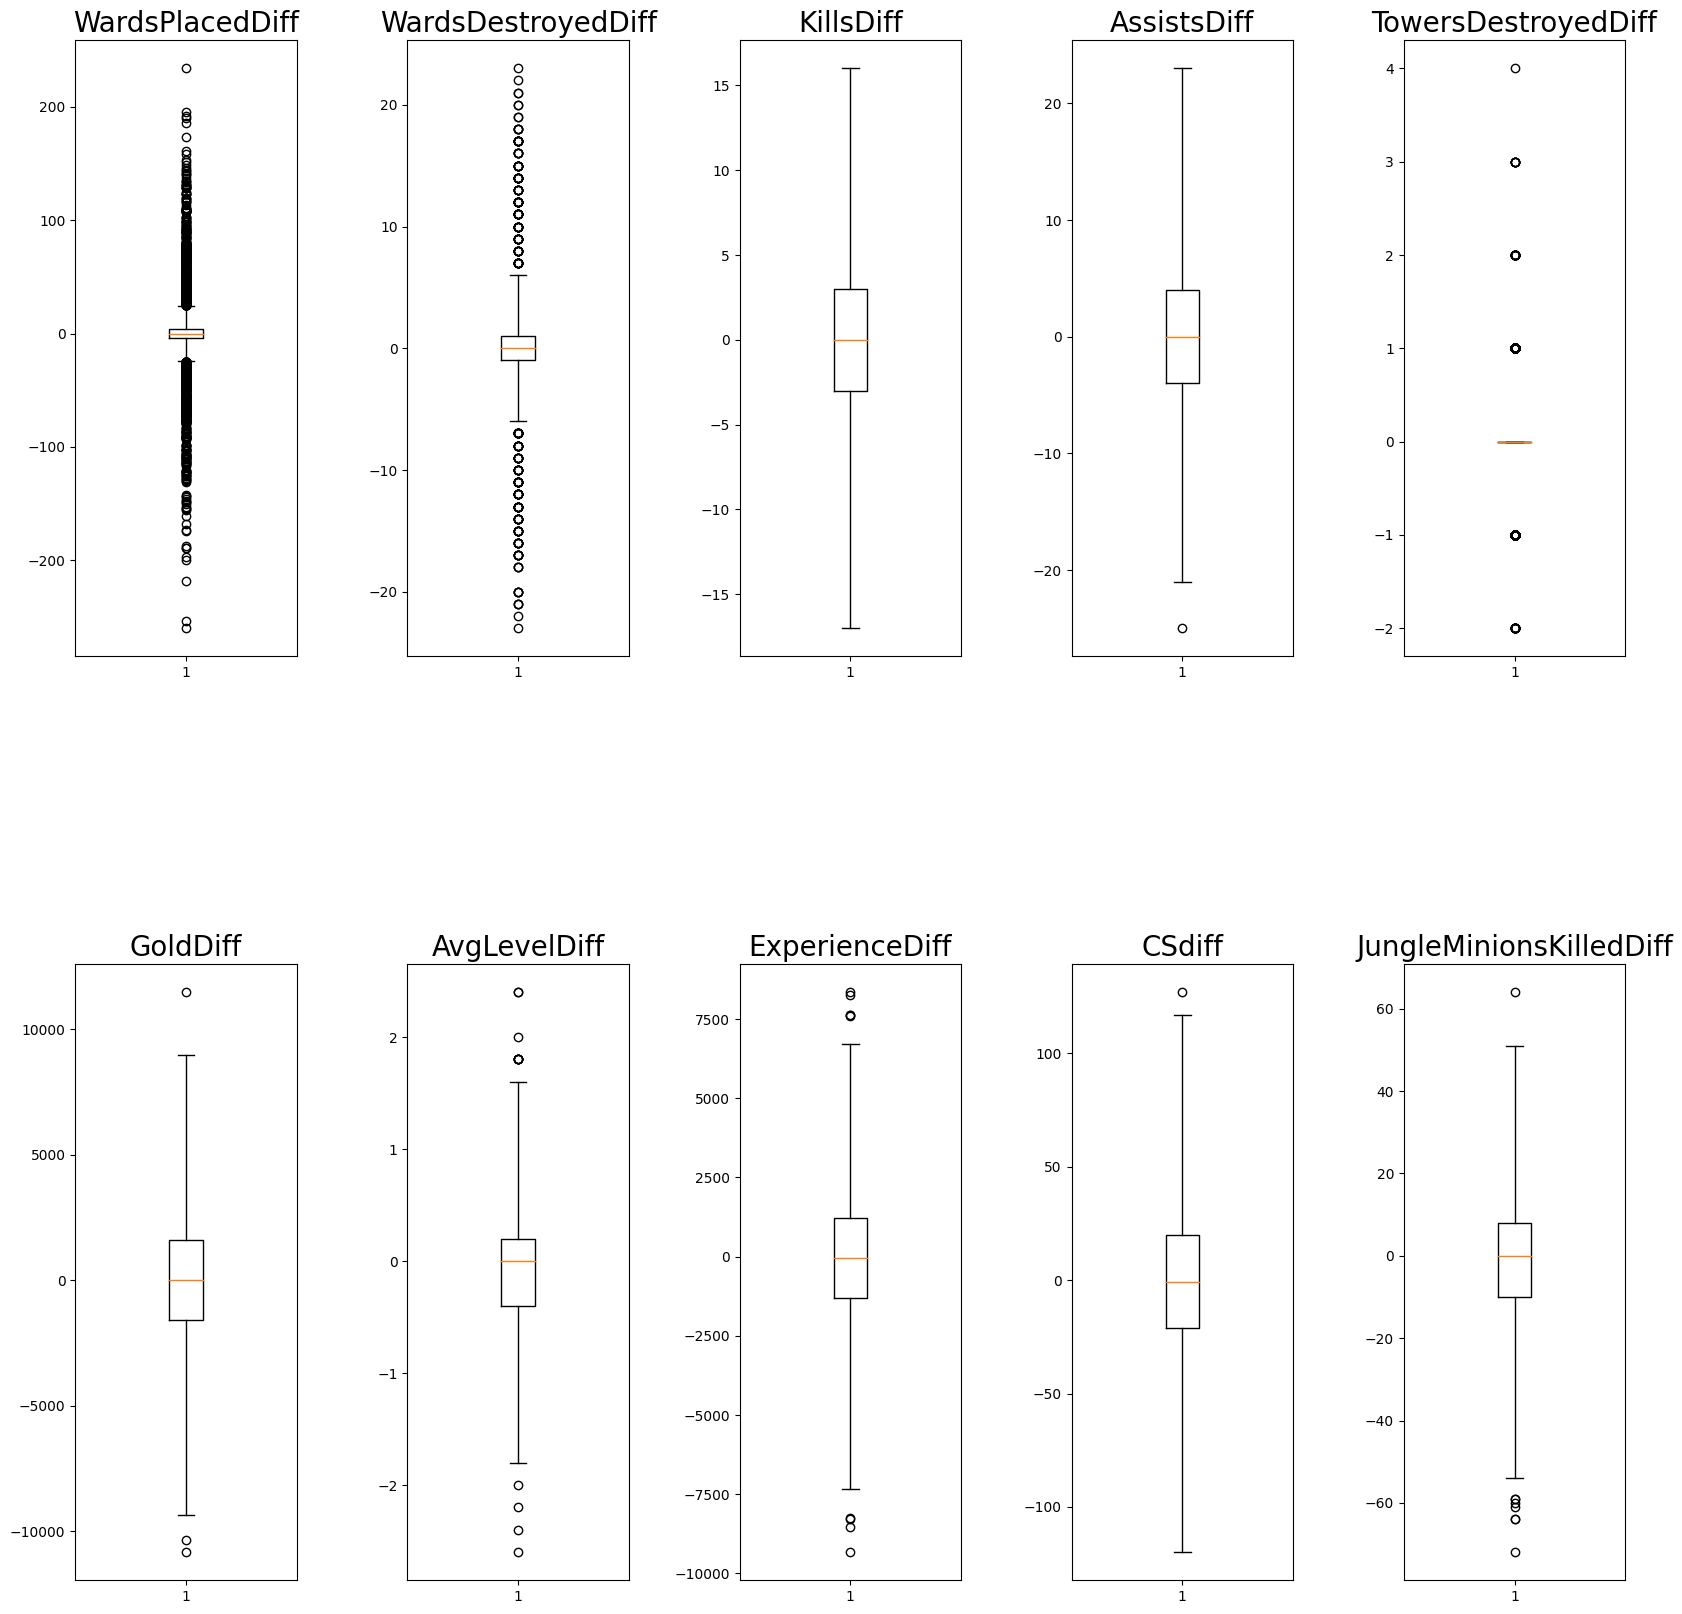

In [ ]:
#boxplots
fig, ax = plt.subplots(2,5, figsize=(20,20))
i = 0
for _ in cont_features:
  ax[i//5, i%5].boxplot(df[_], whis = 2.5)
  ax[i//5, i%5].set_title(_, fontsize=20)
  i += 1
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [ ]:
#normalization check
norm_features = ["KillsDiff", "AssistsDiff","GoldDiff", "AvgLevelDiff", "ExperienceDiff", "CSdiff", "JungleMinionsKilledDiff"]
normality = pd.DataFrame(index=[_ for _ in norm_features])
normality["SWtest"] = [round(stats.shapiro(df[_])[0],4) for var in norm_features]
normality["p-value"] = [round(stats.shapiro(df[_])[1],4) for var in norm_features]
normality["KStest"] = [round(stats.kstest(df[_], stats.norm.cdf)[0],4) for var in norm_features]
normality["p-value2"] = [round(stats.kstest(df[_], stats.norm.cdf)[1],4) for var in norm_features]
display(normality)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,SWtest,p-value,KStest,p-value2
KillsDiff,0.9973,0.0,0.4462,0.0
AssistsDiff,0.9973,0.0,0.4462,0.0
GoldDiff,0.9973,0.0,0.4462,0.0
AvgLevelDiff,0.9973,0.0,0.4462,0.0
ExperienceDiff,0.9973,0.0,0.4462,0.0
CSdiff,0.9973,0.0,0.4462,0.0
JungleMinionsKilledDiff,0.9973,0.0,0.4462,0.0


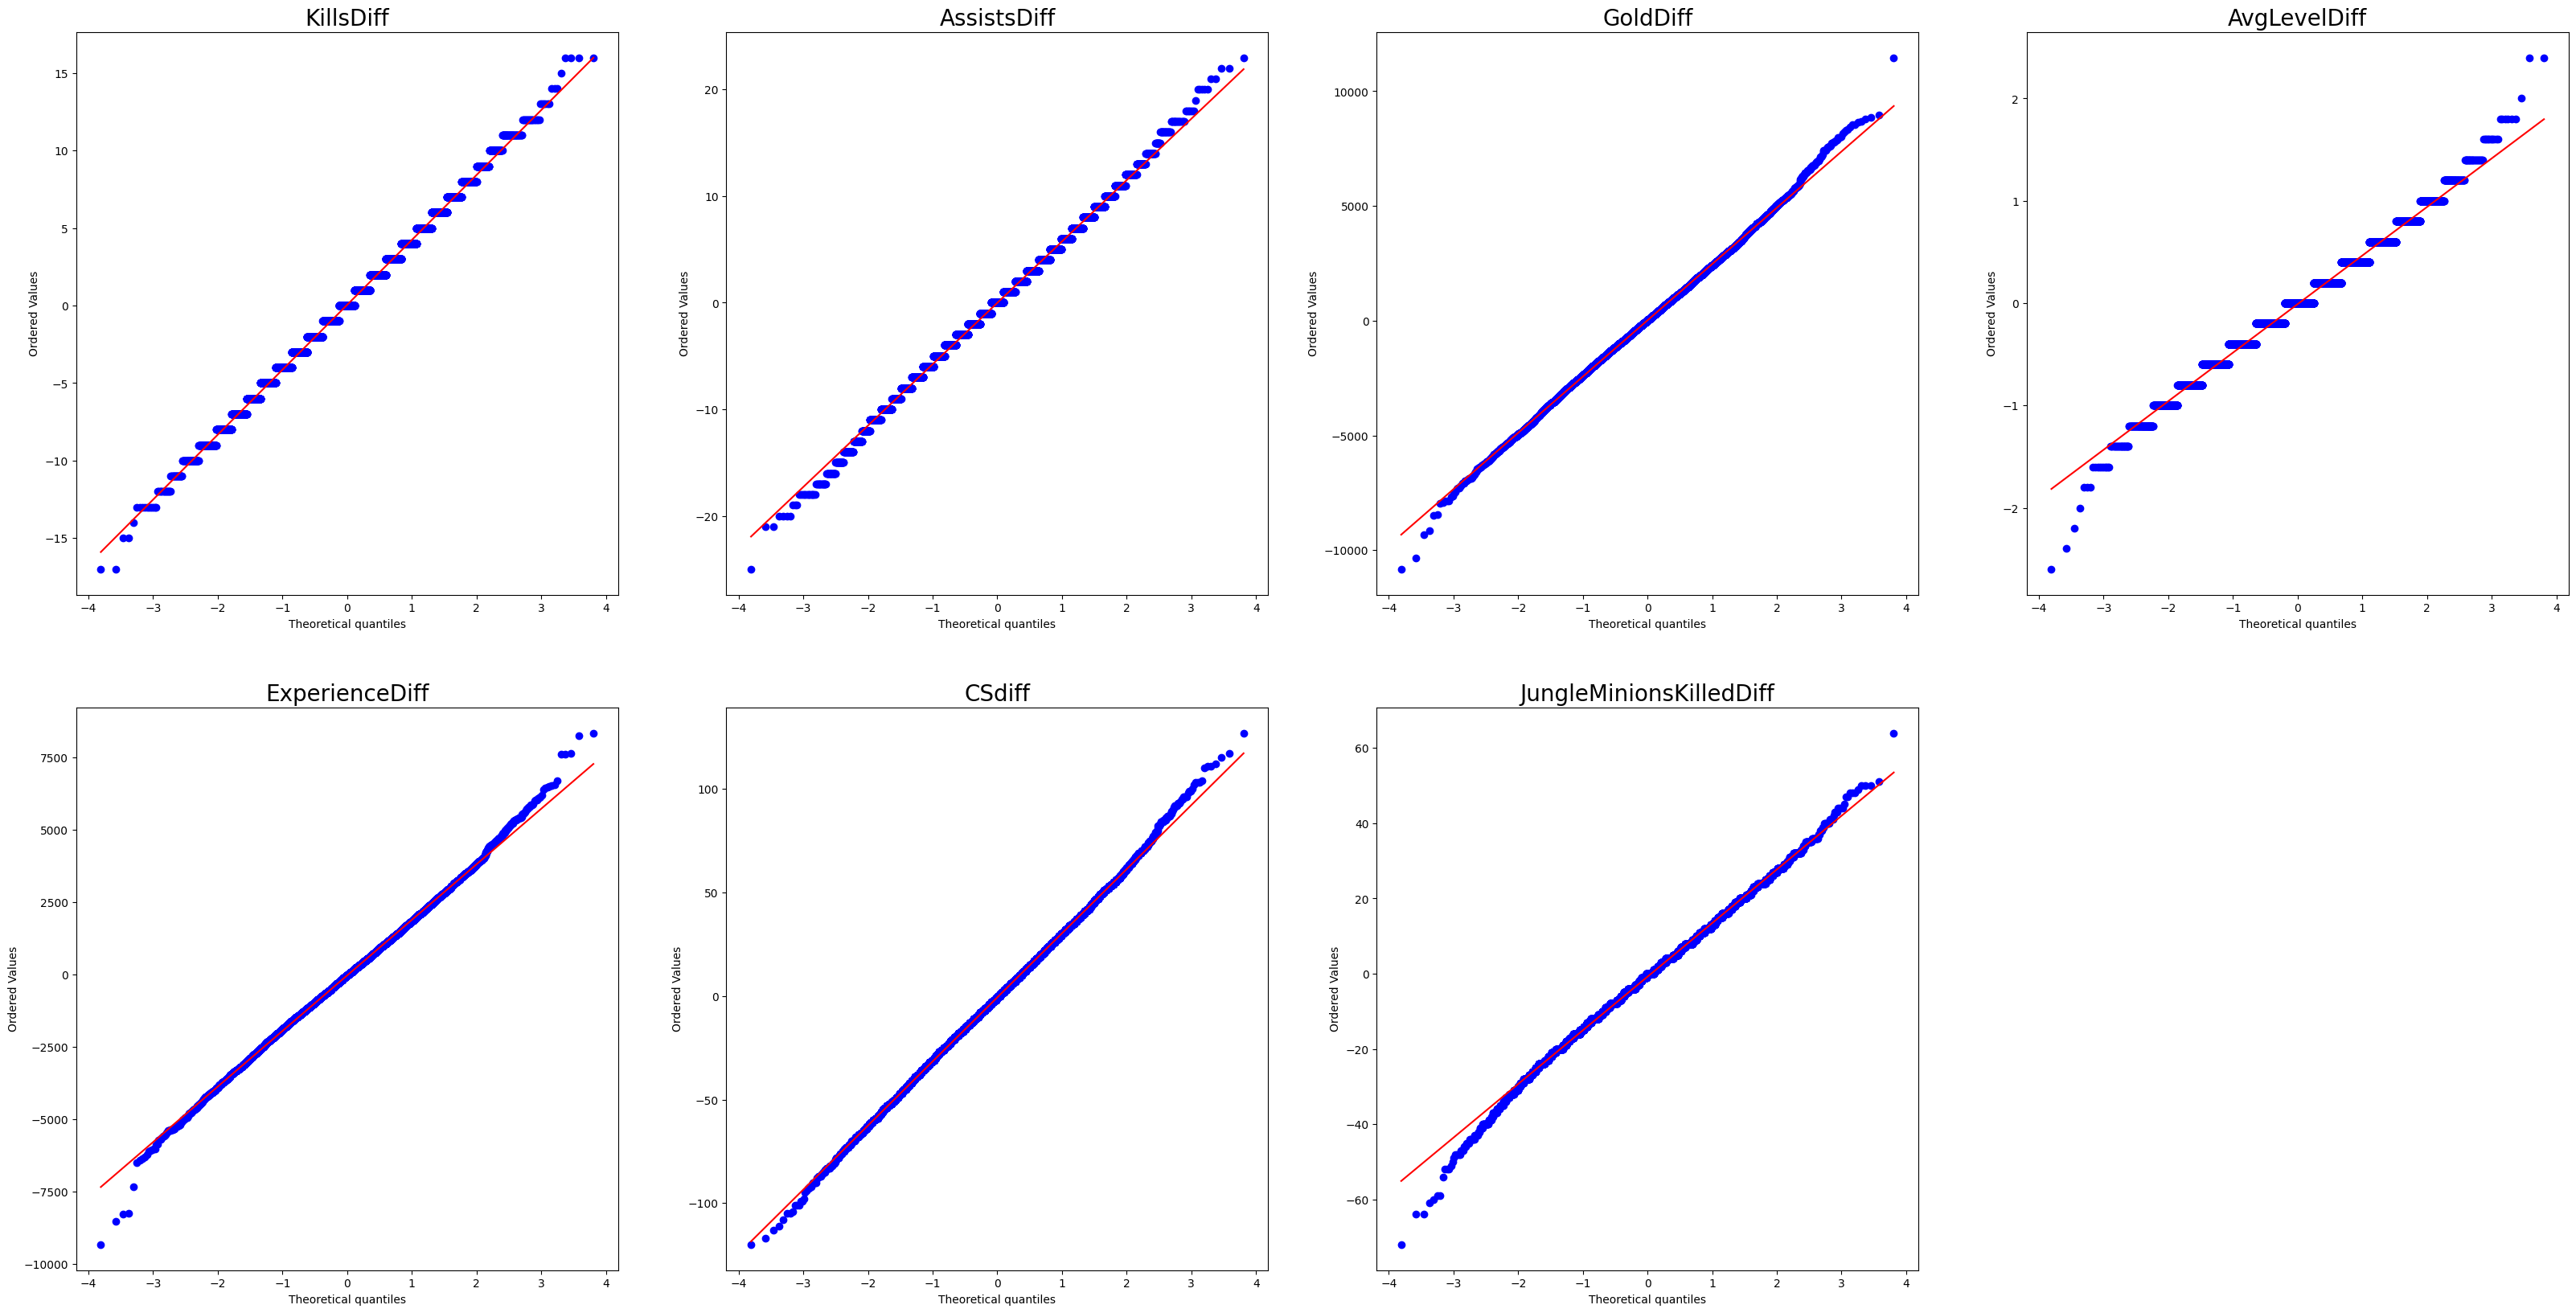

In [ ]:
#QQ-plot
fig, ax = plt.subplots(2,4, figsize=(40,20))
i = 0
for _ in norm_features:
  stats.probplot(df[_], dist=stats.norm, plot=ax[i//4, i%4])
  ax[i//4, i%4].set_title(_, fontsize=20)
  i += 1
plt.subplots_adjust(wspace=0.2, hspace=0.2)
fig.delaxes(ax[1,3])
plt.show()

In [ ]:
#dropping outliers
drop_features = ["WardsPlacedDiff", "WardsDestroyedDiff", "KillsDiff", "AssistsDiff",
                "GoldDiff", "AvgLevelDiff", "ExperienceDiff", "CSdiff", "JungleMinionsKilledDiff"]
for _ in drop_features:
  q1 = df[_].quantile(0.25)
  q3 = df[_].quantile(0.75)
  iqr = q3-q1
  df = df[(df[_] <= q3 + 2.5*iqr)&(df[_] >= q1 - 2.5*iqr)]

In [ ]:
features = cat_features + cont_features
cat_features.append("TowersDestroyedDiff")

In [ ]:
#scatterplots
fig, ax = plt.subplots(13,6, figsize=(40,80))
i = 0
for feat1 in features:
  for feat2 in features[features.index(feat1)+1:]:
    if (feat1 in (cat_features))|(feat2 in (cat_features)): 
      ax[i//6, i%6].set_title(f"{feat1} & {feat2}", fontsize=20)
      sns.stripplot(data=df, x=feat1, y=feat2, ax = ax[i//6, i%6], jitter = True)
    else:
      ax[i//6, i%6].scatter(df[feat1],df[feat2])
      ax[i//6, i%6].set_title(f"{feat1} & {feat2}", fontsize=20)
    i += 1
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
corr = df[cont_features].corr()

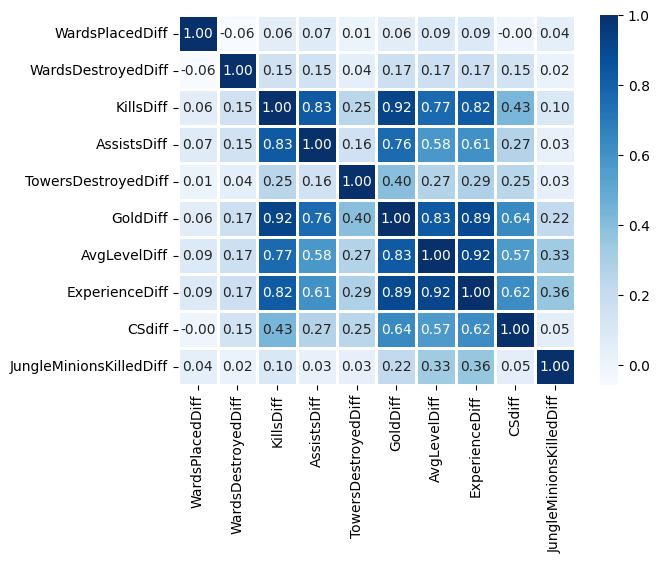

In [ ]:
sns.heatmap(corr, annot=True, fmt='.2f', linewidths = 1, cmap="Blues")
plt.show()

In [ ]:
#LR modeling
def perf_eval_clf(y_true, y_pred)->list:
  tn, fp, fn, tp = cm.ravel()
  TPR = round(tp/(tp+fn),3)
  PRE = round(tp/(tp+fp),3)
  TNR = round(tn/(fp+tn),3)
  ACC = round((tp+tn)/(tn+fp+fn+tp),3)
  BCR = round(np.sqrt([TPR*TNR])[0],3)
  F1 = round(2*TPR*PRE/(TPR+PRE),3)
  return [TPR,PRE,TNR,ACC,BCR,F1]

In [ ]:
def display_result(result_dict: dict, metric_names: list):
  result_df = pd.DataFrame(result_dict).T
  result_df.index = list(result_dict.keys())
  result_df.columns = metric_names
  display(result_df)

result_dict= {}

In [ ]:
input = df.iloc[:,2:]
input_scaled = scale(input, axis = 0, with_mean = True, with_std = True)
input_scaled = pd.DataFrame(input_scaled)
input_scaled.rename(columns = {0:'FirstBlood',
1:'WardsPlacedDiff',
 2:'WardsDestroyedDiff',
 3:'KillsDiff',
 4:'AssistsDiff',
 5:'Dragons',
 6:'Heralds',
 7:'TowersDestroyedDiff',
 8:'GoldDiff',
 9:'AvgLevelDiff',
 10:'ExperienceDiff',
 11:'CSdiff',
 12:'JungleMinionsKilledDiff'}, inplace = True)
output = pd.DataFrame(df.loc[:,"blueWins"])
output = output.reset_index()
df2 = pd.concat((output, input_scaled), axis = 1)

In [ ]:
seed = 555
test_size = 0.3
lol_trn, lol_test = train_test_split(df2, test_size= test_size, random_state =seed)

x_trn = lol_trn.iloc[:,2:]
y_trn = lol_trn.iloc[:,1]

full_lr = LogisticRegression(solver='liblinear', random_state = seed, max_iter = 10000)
full_lr.fit(x_trn, y_trn)

LogisticRegression(max_iter=10000, random_state=555, solver='liblinear')

In [ ]:
def logit_pvalue(model,x,feature_names,cls=0):
  p1 = model.predict_proba(x)
  n1 = len(p1)
  m1 = len(model.coef_[cls]) + 1
  if len(model.intercept_)>1:
    feature_names=['constant'] + feature_names
    coefs = np.concatenate([np.array(model.intercept_[cls].reshape(1,)), model.coef_[cls]])
  elif len(model.intercept_)==1:
    feature_names=['constant'] + feature_names
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
  else:
    coefs = model.coef_[cls]
  x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
  answ = np.zeros((m1, m1))
  for i in range(n1):
    answ = answ + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p1[i,1] * p1[i, 0]
  vcov = np.linalg.inv(np.matrix(answ))
  se = np.sqrt(np.diag(vcov))
  t1 = coefs/se
  p1 = (1 - norm.cdf(abs(t1))) * 2
  pvalue_dict = {key:round(value,4) for key,value in zip(feature_names,p1)}
  display(pd.DataFrame(pvalue_dict,columns=pvalue_dict.keys(),index=['P-value']).T)
  
logit_pvalue(full_lr,x_trn,features)

,P-value
constant,0.7254
FirstBlood,0.0419
Dragons,0.4015
Heralds,0.5130
WardsPlacedDiff,0.6276
WardsDestroyedDiff,0.0853
KillsDiff,0.0000
AssistsDiff,0.1458
TowersDestroyedDiff,0.0286
GoldDiff,0.0000


In [ ]:
x_tst = lol_test.iloc[:,2:]
lr_target = y_tst = lol_test.iloc[:,1]

lr_response = full_lr.predict(x_tst)
cm = confusion_matrix(lr_target,lr_response)

clf_results = perf_eval_clf(lr_target,lr_response)
result_dict['Full Variables'] = clf_results
metric_names = ['TPR(Recall)', 'Precision','TNR','ACC','BCR','F1']
display_result(result_dict,metric_names)
print(f'\n confusion matrix : \n {cm}')

,TPR(Recall),Precision,TNR,ACC,BCR,F1
Full Variables,0.715,0.726,0.736,0.726,0.725,0.72



 confusion matrix : 
 [[1104  395]
 [ 418 1047]]


In [ ]:
#AUROC of testing set /full features
lr_proba = full_lr.predict_proba(x_tst)
probs = [lr_proba[i][1] for i in range(len(lr_proba))]

def ROC(pred, ans):
  res = pd.DataFrame({"predict": pred, "ans":ans})
  res = res.sort_values("predict", ascending = False)
  x, y = [], []
  for i in range(len(pred)):
   temp = res.iloc[:(i+1),:]
   x.append(np.shape(temp[temp["ans"] == 0])[0] / len(ans[ans == 0]))
   y.append(np.shape(temp[temp["ans"] == 1])[0] / len(ans[ans == 1]))
  plt.plot(x, y)
  plt.set_xlabel("True Negative Rate")
  plt.set_ylabel("True Positive Rate")
  plt.set_title("ROC curve")
  return plt, auc(x,y)

ROC(probs, y_tst)

(<Axes: title={'center': 'ROC curve'}, xlabel='True Negative Rate', ylabel='True Positive Rate'>,
 0.8115790504249705)

In [ ]:
#AUROC of the training set /full features
lr_proba_tst = full_lr.predict_proba(x_trn)
probs_tst = [lr_proba_tst[i][1] for i in range(len(lr_proba_tst))]

ROC(probs_tst, y_trn)

TypeError: ignored

In [ ]:
#reduced Dataset
reduced_features = ['FirstBlood', 'WardsPlacedDiff', 'WardsDestroyedDiff','Dragons', 'Heralds', 'TowersDestroyedDiff','GoldDiff', 'CSdiff','JungleMinionsKilledDiff']
xr_trn = lol_trn.loc[:,reduced_features]

reduced_lr = LogisticRegression(solver='liblinear', random_state = seed, max_iter = 10000)
reduced_lr.fit(xr_trn, y_trn)

logit_pvalue(reduced_lr,xr_trn,reduced_features)

,P-value
constant,0.6813
FirstBlood,0.6470
WardsPlacedDiff,0.4117
WardsDestroyedDiff,0.6585
Dragons,0.0000
Heralds,0.0023
TowersDestroyedDiff,0.0005
GoldDiff,0.0000
CSdiff,0.5402
JungleMinionsKilledDiff,0.0085


In [ ]:
xr_tst = lol_test.loc[:,reduced_features]

lrr_response = reduced_lr.predict(xr_tst)
cm = confusion_matrix(lr_target,lrr_response)

clf_results = perf_eval_clf(lr_target,lrr_response)
result_dict['Reduced Variables'] = clf_results
metric_names = ['TPR(Recall)', 'Precision','TNR','ACC','BCR','F1']
display_result(result_dict,metric_names)
print(f'\n confusion matrix : \n {cm}')

,TPR(Recall),Precision,TNR,ACC,BCR,F1
Full Variables,0.719,0.733,0.731,0.725,0.725,0.726
Reduced Variables,0.717,0.729,0.727,0.722,0.722,0.723
"All Variables, SAGA",0.717,0.729,0.727,0.722,0.722,0.723
Forward Selection,0.717,0.729,0.727,0.722,0.722,0.723
Backward Elimination,0.717,0.729,0.727,0.722,0.722,0.723
Stepwise Selection,0.717,0.729,0.727,0.722,0.722,0.723
Genetic Algorithm,0.717,0.729,0.727,0.722,0.722,0.723


(<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>,
 0.801169068853466)

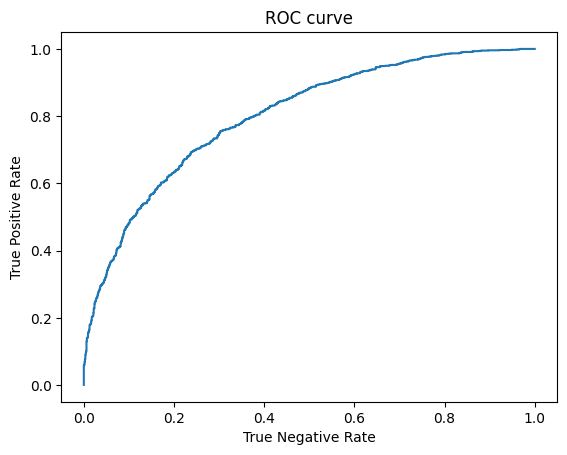

In [ ]:
#AUROC of testing set /reduced features
lrr_proba = reduced_lr.predict_proba(xr_tst)
probs = [lrr_proba[i][1] for i in range(len(lrr_proba))]

ROC(probs, y_tst)

(<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>,
 0.8124132698165366)

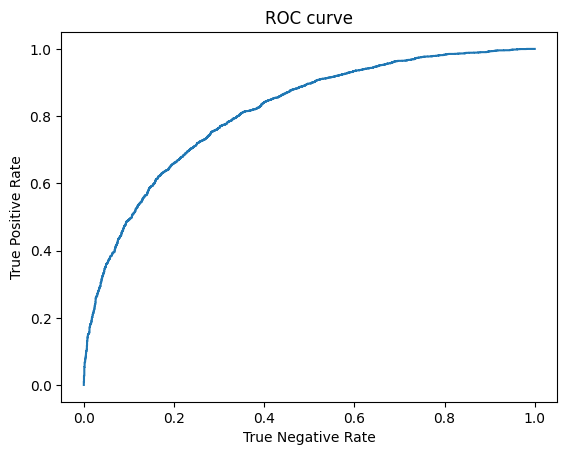

In [ ]:
#AUROC of the training set /reduced features
lrr_proba_tst = reduced_lr.predict_proba(xr_trn)
probs_r_tst = [lrr_proba_tst[i][1] for i in range(len(lrr_proba_tst))]

ROC(probs_r_tst, y_trn)

#@ Feature Selection

In [ ]:
#feature selection
full_config = {
'penalty':None,
'fit_intercept':True,
'max_iter':10000,
'solver':'saga',
'random_state':seed,
'n_jobs':-1
}

#save the name of selected features
features_dict = {}
features_dict["All Variables"] = ['constant'] + features


full_model = LogisticRegression(**full_config).fit(x_trn, y_trn)
logit_pvalue(full_model, x_trn, features)

y_pred = full_model.predict(x_tst)
result_dict["All Variables, SAGA"] = perf_eval_clf(y_tst, y_pred)
display_result(result_dict, metric_names)

,P-value
constant,0.7249
FirstBlood,0.0446
Dragons,0.3981
Heralds,0.5159
WardsPlacedDiff,0.5357
WardsDestroyedDiff,0.0761
KillsDiff,0.0000
AssistsDiff,0.1477
TowersDestroyedDiff,0.0228
GoldDiff,0.0000


,TPR(Recall),Precision,TNR,ACC,BCR,F1
Full Variables,0.715,0.726,0.736,0.726,0.725,0.72
"All Variables, SAGA",0.715,0.726,0.736,0.726,0.725,0.72


In [ ]:
input_idx = [2,3,4,5,6,7,8,9,10,11,12,13,14]
target_idx = 1

In [ ]:
#forward selection
import time
sec = time.time()

full_config = {
'penalty':'none',
'fit_intercept':True,
'max_iter':10000,
'solver':'saga',
'random_state':seed,
'n_jobs':-1
}
full_model = LogisticRegression(**full_config)

forward_config = {
'estimator':full_model,
'n_features_to_select':'auto',
'tol':1e-4,
'direction':'forward',
'scoring':'f1',
'cv':5,
'n_jobs':-1
}
forward_selection = SFS(**forward_config).fit(x_trn,y_trn)
features_dict['Forward Selection'] = forward_features = forward_selection.get_feature_names_out()
print(forward_features)
print(f'time for forward selection:{time.time() - sec}')

['KillsDiff' 'Dragons' 'Heralds' 'GoldDiff' 'ExperienceDiff']
7.086820840835571


In [ ]:
x_trn_forward = x_trn[forward_features]
x_tst_forward = x_tst[forward_features]
forward_logit = LogisticRegression(**full_config).fit(x_trn_forward, y_trn)

y_predf = forward_logit.predict(x_tst_forward)
result_dict["Forward Selection"] = perf_eval_clf(y_tst, y_predf)
display_result(result_dict, metric_names)

,TPR(Recall),Precision,TNR,ACC,BCR,F1
Full Variables,0.719,0.733,0.731,0.725,0.725,0.726
Reduced Variables,0.717,0.729,0.727,0.722,0.722,0.723
"All Variables, SAGA",0.717,0.729,0.727,0.722,0.722,0.723
Forward Selection,0.717,0.729,0.727,0.722,0.722,0.723
Backward Elimination,0.717,0.729,0.727,0.722,0.722,0.723
Stepwise Selection,0.717,0.729,0.727,0.722,0.722,0.723
Genetic Algorithm,0.717,0.729,0.727,0.722,0.722,0.723


In [ ]:
#Backwards Elimination
import time
sec = time.time()

full_config = {
'penalty':'none',
'fit_intercept':True,
'max_iter':10000,
'solver':'saga',
'random_state':seed,
'n_jobs':-1
}
full_model = LogisticRegression(**full_config)

backward_config = {
'estimator':full_model,
'n_features_to_select':'auto',
'tol':1e-3,
'direction':'backward',
'scoring':'f1',
'cv':5,
'n_jobs':-1
}
backward_elimination = SFS(**backward_config).fit(x_trn,y_trn)
features_dict['Backward Elimination'] = backward_features = backward_elimination.get_feature_names_out()
print(backward_features)
print(f'time for backward elimination:{time.time() - sec}')

['FirstBlood' 'WardsPlacedDiff' 'WardsDestroyedDiff' 'KillsDiff'
 'AssistsDiff' 'Dragons' 'Heralds' 'TowersDestroyedDiff' 'GoldDiff'
 'AvgLevelDiff' 'CSdiff' 'JungleMinionsKilledDiff']
6.286331653594971


In [ ]:
x_trn_backward = x_trn[backward_features]
x_tst_backward = x_tst[backward_features]
backward_logit = LogisticRegression(**full_config).fit(x_trn_backward,y_trn)
y_predb = backward_logit.predict(x_tst_backward)
result_dict['Backward Elimination'] = perf_eval_clf(y_tst,y_predb)
display_result(result_dict, metric_names)
print(f'\n confusion matrix: \n {cm}')

,TPR(Recall),Precision,TNR,ACC,BCR,F1
Full Variables,0.719,0.733,0.731,0.725,0.725,0.726
Reduced Variables,0.717,0.729,0.727,0.722,0.722,0.723
"All Variables, SAGA",0.717,0.729,0.727,0.722,0.722,0.723
Forward Selection,0.717,0.729,0.727,0.722,0.722,0.723
Backward Elimination,0.717,0.729,0.727,0.722,0.722,0.723
Stepwise Selection,0.717,0.729,0.727,0.722,0.722,0.723
Genetic Algorithm,0.717,0.729,0.727,0.722,0.722,0.723


In [ ]:
#stepwise
import time
sec = time.time()
full_config = {
'penalty':'none',
'fit_intercept':True,
'max_iter':10000,
'solver':'saga',
'random_state':seed,
'n_jobs':-1
}
full_model = LogisticRegression(**full_config)

stepwise_config = {
'estimator':full_model,
'n_features_to_select':'auto',
'tol':None,
'direction':'forward',
'scoring':'f1',
'cv':5,
'n_jobs':-1
}
stepwise_selection =SFS(**stepwise_config).fit(x_trn,y_trn)
features_dict['Stepwise Selection']= stepwise_features =stepwise_selection.get_feature_names_out()
print(stepwise_features)

print(f'time for stepwise:{time.time() - sec}')

['KillsDiff' 'Dragons' 'Heralds' 'GoldDiff' 'ExperienceDiff'
 'JungleMinionsKilledDiff']
7.020598411560059


In [ ]:
x_trn_stepwise = x_trn[stepwise_features]
x_tst_stepwise = x_tst[stepwise_features]
stepwise_logit = LogisticRegression(**full_config).fit(x_trn_stepwise,y_trn)
y_preds = stepwise_logit.predict(x_tst_stepwise)
result_dict['Stepwise Selection'] = perf_eval_clf(y_tst,y_preds)
display_result(result_dict, metric_names)
print(f'\n confusion matrix: \n {cm}')

,TPR(Recall),Precision,TNR,ACC,BCR,F1
Full Variables,0.719,0.733,0.731,0.725,0.725,0.726
Reduced Variables,0.717,0.729,0.727,0.722,0.722,0.723
"All Variables, SAGA",0.717,0.729,0.727,0.722,0.722,0.723
Forward Selection,0.717,0.729,0.727,0.722,0.722,0.723
Backward Elimination,0.717,0.729,0.727,0.722,0.722,0.723
Stepwise Selection,0.717,0.729,0.727,0.722,0.722,0.723


In [ ]:
def AUROC(pred, ans):
  res = pd.DataFrame({"predict": pred, "ans":ans})
  res = res.sort_values("predict", ascending = False)
  x, y = [], []
  for i in range(len(pred)):
   temp = res.iloc[:(i+1),:]
   x.append(np.shape(temp[temp["ans"] == 0])[0] / len(ans[ans ==0]))
   y.append(np.shape(temp[temp["ans"] == 1])[0] / len(ans[ans ==1]))
  return auc(x,y)

In [ ]:
#GA

class GeneticAlgorithm(object):
  def __init__(self, population_size:int, n_feat:int, n_parents:int, n_gen: int, init_rate: float, mutation_rate: float, crossover_rate:float, model: object, seed: int):
    self.population_size = population_size
    self.n_feat = n_feat
    self.n_parents = n_parents
    self.n_gen = n_gen
    self.init_rate = init_rate
    self.mutation_rate = mutation_rate
    self.crossover_rate = crossover_rate
    self.model = model
    self.seed = seed

  def initialization_of_population(self,size: int, n_feat: int, init_prob: float)->list:
    population = []
    for i in range(size):
      chromosome = np.bool_(np.ones(n_feat))
      chromosome[:int(init_prob*n_feat)]=False
      np.random.shuffle(chromosome)
      population.append(chromosome)
    return population

  def fitness_score(self, model, population:list, X_train:Union[np.array,pd.DataFrame], Y_train:Union[np.array,pd.DataFrame]):
    scores = []
    for chromosome in population:
      model.fit(X_train.iloc[:,chromosome],Y_train)
      predictions = model.predict_proba(X_train.iloc[:,chromosome])
      pred = [predictions[i][1] for i in range(len(Y_train))]
      scores.append(AUROC(Y_train, pred))
    scores, population = np.array(scores), np.array(population)
    inds = np.argsort(scores) #ascending orders
    return list(scores[inds][::-1]), list(population[inds,:][::-1])

  def selection(self,pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
     population_nextgen.append(pop_after_fit[i])
    return population_nextgen
  
  def crossover(self,pop_after_sel:list,crossover_rate:float):
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
      new_par = []
      child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
      select_idx = np.random.random_sample(len(child_1)) > crossover_rate
      for j in range(len(child_1)):
        new_par.append(child_1[j] if select_idx[j] else child_2[j])
      pop_nextgen.append(new_par)
    return pop_nextgen

  def mutation(self, pop_after_cross:list, mutation_rate:float, n_feat:int):
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
      chromo = pop_after_cross[n]
      rand_posi = []
      for i in range(0,mutation_range):
        pos = np.random.randint(0,n_feat-1)
        rand_posi.append(pos)
      for j in rand_posi:
        chromo[j] = not chromo[j]
      pop_next_gen.append(chromo)
    return pop_next_gen

  def fit(self, x_trn:Union[np.array, pd.DataFrame], y_trn:Union[np.array, pd.Series,list,]):
    np.random.seed(self.seed)
    best_chromo= []
    best_score= []
    population_nextgen = self.initialization_of_population(self.population_size, self.n_feat, self.init_rate)
    for i in range(self.n_gen):
      scores, pop_after_fit = self.fitness_score(self.model, population_nextgen, x_trn, y_trn)
      best_chromo.append(pop_after_fit[0])
      best_score.append(scores[0])
      print('Best score(Training) in generation',i+1,':',scores[:1]) #2
      pop_after_sel = self.selection(pop_after_fit,self.n_parents)
      pop_after_cross = self.crossover(pop_after_sel,self.crossover_rate)
      population_nextgen = self.mutation(pop_after_cross, self.mutation_rate, self.n_feat)

    return best_chromo, best_score

In [ ]:
sec = time.time()
full_config = {
  'penalty':'none',
  'fit_intercept':True,
  'max_iter':10000,
  'solver':'saga',
  'random_state':seed,
  'n_jobs':-1
}
full_model = LogisticRegression(**full_config)

genetic_config={
  'population_size':20,
  'n_feat':13,
  'n_parents':2,
  'n_gen':5,
  'init_rate':0.3,
  'mutation_rate':0.1,
  'crossover_rate':0.3,
  'model':full_model,
  'seed':seed
}

GA = GeneticAlgorithm(**genetic_config)
bestchromo, bestscores = GA.fit(x_trn,y_trn)
features_dict['Genetic Algorithm'] = genetic_features = np.array(features)[bestchromo[np.argmax(bestscores)]].tolist()
print(genetic_features, metric_names)
print(f'time for GA:{time.time() - sec}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:11

Best score(Training) in generation 1 : [0.0]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Best score(Training) in generation 2 : [0.0]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Best score(Training) in generation 3 : [0.0]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Best score(Training) in generation 4 : [0.0]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Best score(Training) in generation 5 : [0.0]
['FirstBlood', 'Dragons', 'WardsPlacedDiff', 'WardsDestroyedDiff', 'KillsDiff', 'AssistsDiff', 'TowersDestroyedDiff', 'GoldDiff', 'ExperienceDiff', 'CSdiff', 'JungleMinionsKilledDiff'] ['TPR(Recall)', 'Precision', 'TNR', 'ACC', 'BCR', 'F1']
171.5508749485016


In [ ]:
x_trn_genetic = x_trn[genetic_features]
x_tst_genetic = x_tst[genetic_features]
genetic_logit = LogisticRegression(**full_config).fit(x_trn_genetic,y_trn)
y_predg = genetic_logit.predict(x_tst_genetic)
result_dict['Genetic Algorithm'] = perf_eval_clf(y_tst,y_predg)
display_result(result_dict, metric_names)

,TPR(Recall),Precision,TNR,ACC,BCR,F1
Full Variables,0.719,0.733,0.731,0.725,0.725,0.726
Reduced Variables,0.717,0.729,0.727,0.722,0.722,0.723
"All Variables, SAGA",0.717,0.729,0.727,0.722,0.722,0.723
Forward Selection,0.717,0.729,0.727,0.722,0.722,0.723
Backward Elimination,0.717,0.729,0.727,0.722,0.722,0.723
Stepwise Selection,0.717,0.729,0.727,0.722,0.722,0.723
Genetic Algorithm,0.717,0.729,0.727,0.722,0.722,0.723


In [ ]:
#new confusion matrix - given code doesn't work out so well
def c_m(y_test, y_pred):
  dat = pd.DataFrame([[0,0],
                    [0,0]])
  for _ in range(len(y_test)):
    if ((y_test[_] ==0) & (y_pred[_] == 0)):
      dat[1][1] += 1
    elif ((y_test[_] ==1) & (y_pred[_] == 0)):
      dat[0][1] += 1
    elif ((y_test[_] ==0) & (y_pred[_] == 1)):
      dat[1][0] += 1
    else:
      dat[0][0] += 1
  
  return dat

def perf(dataf):
  performance = {}
  performance["TPR"] = dataf[0][0] / (dataf[0][0] + dataf[0][1])
  performance["Precision"] = dataf[0][0] / (dataf[0][0] + dataf[1][0])
  performance["TNR"] = dataf[1][1] / (dataf[0][1] + dataf[1][1])
  performance["ACC"] = (dataf[0][0] + dataf[1][1]) / (dataf[0][0] + dataf[1][0] + dataf[0][1] + dataf[1][1])
  performance["BCR"] = math.sqrt(performance["TPR"]*performance["TNR"])
  performance["F1"] = 2* performance["TPR"]*performance["Precision"]/(performance["TPR"]+performance["Precision"])
  return performance
tst = np.array(y_tst)

In [ ]:
#compare reduction methods
res = []
for y in [y_pred, y_predg, y_predf, y_predb, y_preds]:
  res.append(perf(c_m(tst, y)))
print(res)

NameError: ignored

In [ ]:
def AUROC(pred, ans):
  res = pd.DataFrame({"predict": pred, "ans":ans})
  res = res.sort_values("predict", ascending = False)
  x, y = [], []
  for i in range(len(pred)):
   temp = res.iloc[:(i+1),:]
   x.append(np.shape(temp[temp["ans"] == 0])[0] / len(ans[ans == 0]))
   y.append(np.shape(temp[temp["ans"] == 1])[0] /len(ans[ans == 1]))
  return auc(x,y)

In [ ]:
AUROCS = {}
#GA
pred = genetic_logit.predict_proba(x_trn_genetic)
pred2 = [pred[i][1] for i in range(len(pred))]
x, y = AUROC(pred2, y_trn)
AUROCS["genetic"] = auc(x,y)
plt.plot(x,y, label="GA")

#forward
pred = forward_logit.predict_proba(x_trn_forward)
pred3 = [pred[i][1] for i in range(len(pred))]
x, y = AUROC(pred3, y_trn)
AUROCS["forward"] = auc(x,y)
plt.plot(x,y, label="Forward")

#backward
pred = backward_logit.predict_proba(x_trn_backward)
pred4 = [pred[i][1] for i in range(len(pred))]
x, y = AUROC(pred4, y_trn)
AUROCS["backward"] = auc(x,y)
plt.plot(x,y, label="Backward")

#stepwise
pred = stepwise_logit.predict_proba(x_trn_stepwise)
pred5 = [pred[i][1] for i in range(len(pred))]
x, y = AUROC(pred5, y_trn)
AUROCS["stepwise"] = auc(x,y)
plt.plot(x,y, label="Stepwise")

y=x
plt.plot(x,y)
plt.legend()
print(pd.DataFrame(AUROCS))

0.8151253628342375
0.8139366463405802
0.8140360025075363
0.8139743813553959


In [ ]:
#GA with varying hyperparameters
full_config = {
  'penalty':'none',
  'fit_intercept':True,
  'max_iter':10000,
  'solver':'saga',
  'random_state':seed,
  'n_jobs':-1
}
full_model = LogisticRegression(**full_config)

genetic_config={
  'population_size':20,
  'n_feat':13,
  'n_parents':2,
  'n_gen':5,
  'init_rate':0.3,
  'mutation_rate':0.1,
  'crossover_rate':0.3,
  'model':full_model,
  'seed':seed
}

GA = GeneticAlgorithm(**genetic_config)
bestchromo, bestscores = GA.fit(x_trn,y_trn)
features_dict['Genetic Algorithm'] = genetic_features = np.array(features)[bestchromo[np.argmax(bestscores)]].tolist()

In [ ]:
#varying hyperparameters
for pop in [5,20,35]:
  for m_rate in [0.001, 0.1, 0.5]:
    for c_rate in [0.1, 0.5, 0.7]:
      genetic_config["population_size"] = pop
      genetic_config["mutation_rate"] = m_rate
      genetic_config["crossover_rate"] = c_rate

      GA = GeneticAlgorithm(**genetic_config)
      bestchromo, bestscores = GA.fit(x_trn, y_trn)
      features_dict[f'Genetic Algorithm{pop},{m_rate},{c_rate}'] = genetic_features = np.array(features)[bestchromo[np.argmax(bestscores)]].tolist()

Best score(Training) in generation 1 : [0.0]
Best score(Training) in generation 2 : [0.0]
Best score(Training) in generation 3 : [0.0]
Best score(Training) in generation 4 : [0.0]
Best score(Training) in generation 5 : [0.0]
Best score(Training) in generation 1 : [0.0]
Best score(Training) in generation 2 : [0.0]
Best score(Training) in generation 3 : [0.0]
Best score(Training) in generation 4 : [0.0]
Best score(Training) in generation 5 : [0.0]
Best score(Training) in generation 1 : [0.0]
Best score(Training) in generation 2 : [0.0]
Best score(Training) in generation 3 : [0.0]
Best score(Training) in generation 4 : [0.0]
Best score(Training) in generation 5 : [0.0]
Best score(Training) in generation 1 : [0.0]
Best score(Training) in generation 2 : [0.0]
Best score(Training) in generation 3 : [0.0]
Best score(Training) in generation 4 : [0.0]
Best score(Training) in generation 5 : [0.0]
Best score(Training) in generation 1 : [0.0]
Best score(Training) in generation 2 : [0.0]
Best score

In [ ]:
GA_hp = pd.DataFrame(index = features_dict.keys(), columns = features)

for key in features_dict.keys():
  for feat in features:
    if feat in features_dict[key]:
      GA_hp.loc[key,feat] = 1
    else:
      GA_hp.loc[key,feat] = 0 

sums = [sum(GA_hp.loc[key,:]) for key in features_dict.keys()]
GA_hp.loc[:,"sum"] = sums
GA_hp = GA_hp.apply(pd.to_numeric)

TypeError: ignored

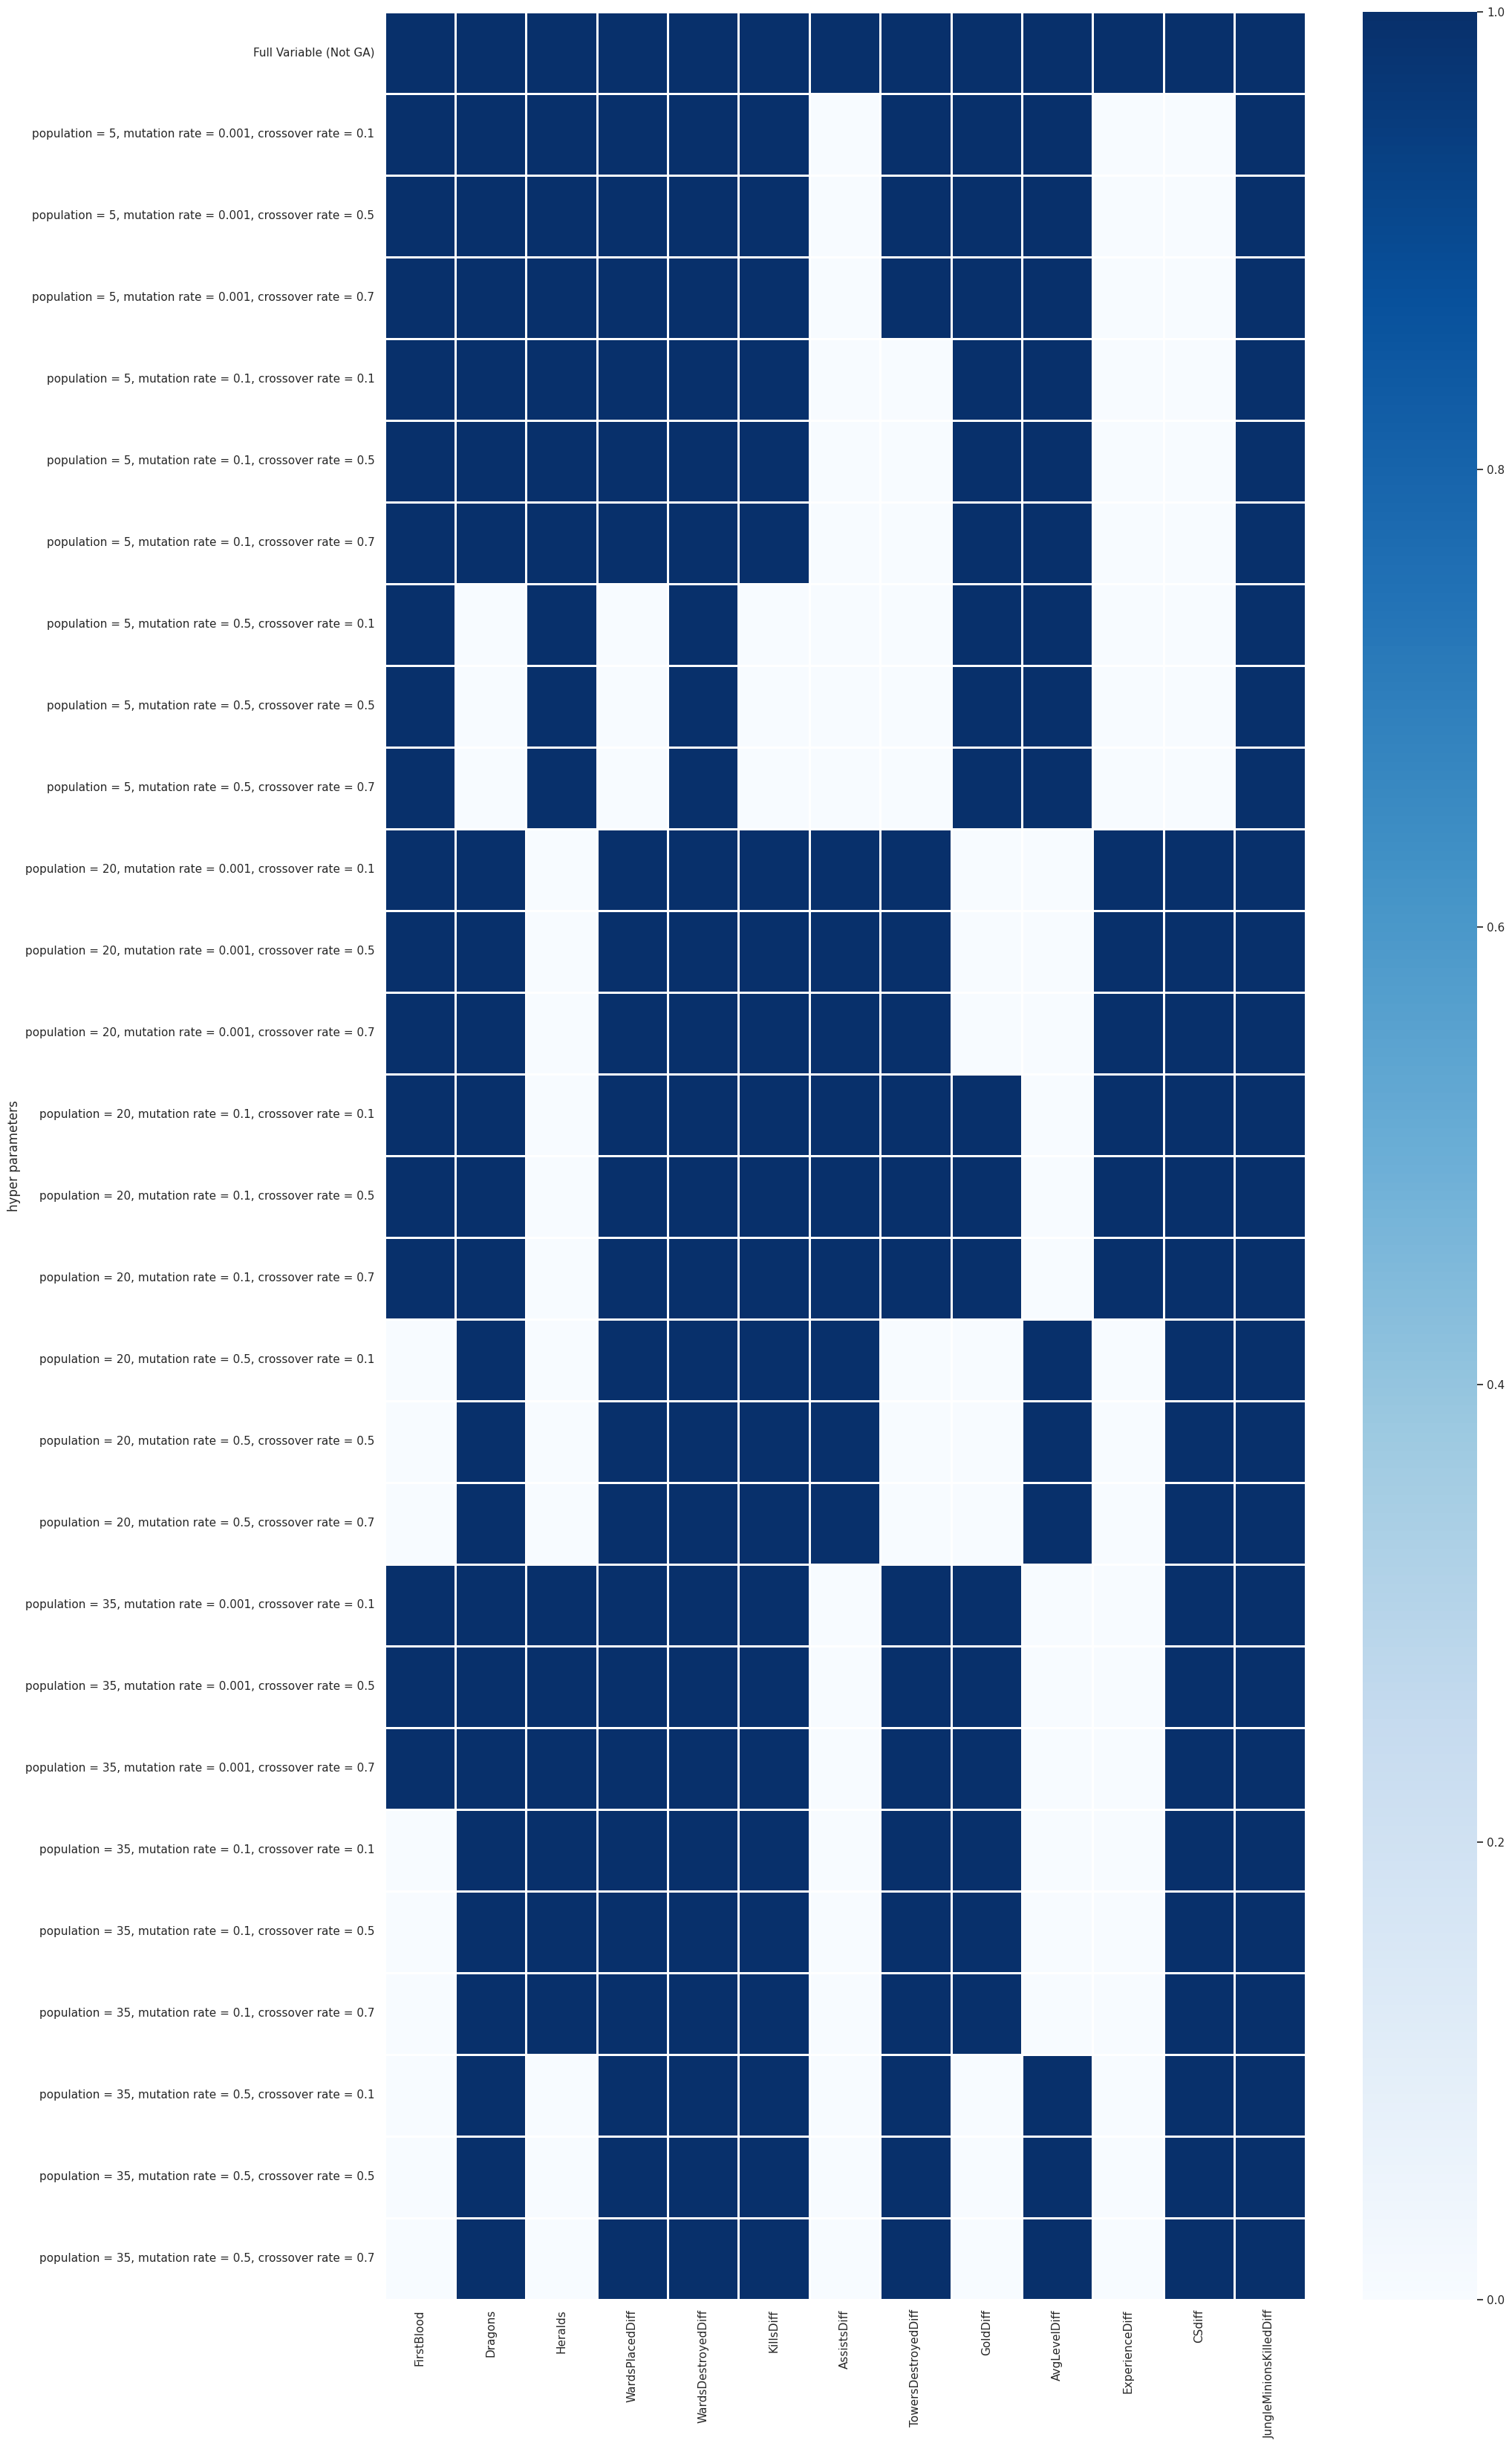

In [ ]:
hyperp = ["Full Variable (Not GA)"]
for i in [5, 20, 35]:
  for j in [0.001, 0.1, 0.5]:
    for k in [0.1, 0.5, 0.7]:
      hyperp.append(f'population = {i}, mutation rate = {j}, crossover rate = {k}')

GA_hp["hyper parameters"] = hyperp
GA_hp = GA_hp.set_index("hyper parameters")

#make a heatmap of features selected over different hyperparameters
plt = sns.heatmap(GA_hp.iloc[:,:13], linewidth= 1, cmap="Blues")
sns.set(rc={'figure.figsize':(20,40)})

In [ ]:
#AUROC, F1-measure for differenct hyperparameters
Results = pd.DataFrame(index = features_dict.keys(), columns = ['Accuracy','AUROC'])

for keys in features_dict.keys():
  x_trn_h = x_trn[features_dict[keys][1:]]
  print(x_trn.columns)
  x_tst_h = x_tst[features_dict[keys][1:]]
  Logit = LogisticRegression(**full_config)
  Logit.fit(x_trn_h, y_trn)
  fpreds = Logit.predict_proba(x_tst_h)
  preds = [fpreds[i][1] for i in range(len(fpreds))]
  Results.loc[keys, 'AUROC'] = AUROC(preds, y_tst)
  print(AUROC(preds, y_tst))

  pred = Logit.predict(x_tst_h)
  df = c_m(list(y_tst), pred)
  Results.loc[keys,'Accuracy'] = perf(df)['F1']
  print(perf(df)['F1'])

display(Results)

Index(['FirstBlood', 'WardsPlacedDiff', 'WardsDestroyedDiff', 'KillsDiff',
       'AssistsDiff', 'Dragons', 'Heralds', 'TowersDestroyedDiff', 'GoldDiff',
       'AvgLevelDiff', 'ExperienceDiff', 'CSdiff', 'JungleMinionsKilledDiff'],
      dtype='object')
0.8115886131140897
0.7214580467675379
Index(['FirstBlood', 'WardsPlacedDiff', 'WardsDestroyedDiff', 'KillsDiff',
       'AssistsDiff', 'Dragons', 'Heralds', 'TowersDestroyedDiff', 'GoldDiff',
       'AvgLevelDiff', 'ExperienceDiff', 'CSdiff', 'JungleMinionsKilledDiff'],
      dtype='object')
0.8112534636287673
0.7250941458404656
Index(['FirstBlood', 'WardsPlacedDiff', 'WardsDestroyedDiff', 'KillsDiff',
       'AssistsDiff', 'Dragons', 'Heralds', 'TowersDestroyedDiff', 'GoldDiff',
       'AvgLevelDiff', 'ExperienceDiff', 'CSdiff', 'JungleMinionsKilledDiff'],
      dtype='object')
0.8112534636287673
0.7250941458404656
Index(['FirstBlood', 'WardsPlacedDiff', 'WardsDestroyedDiff', 'KillsDiff',
       'AssistsDiff', 'Dragons', 'Heralds', 'T

,Accuracy,AUROC
All Variables,0.721458,0.811589
"Genetic Algorithm5,0.001,0.1",0.725094,0.811253
"Genetic Algorithm5,0.001,0.5",0.725094,0.811253
"Genetic Algorithm5,0.001,0.7",0.725094,0.811253
"Genetic Algorithm5,0.1,0.1",0.722184,0.810704
"Genetic Algorithm5,0.1,0.5",0.722184,0.810704
"Genetic Algorithm5,0.1,0.7",0.722184,0.810704
"Genetic Algorithm5,0.5,0.1",0.717227,0.804283
"Genetic Algorithm5,0.5,0.5",0.717227,0.804283
"Genetic Algorithm5,0.5,0.7",0.717227,0.804283


In [ ]:
#Bonus Check
feat = ["Dragons", "GoldDiff", "ExperienceDiff"]
x_trn_f = x_trn[feat]
x_tst_f = x_tst[feat]]
Logit = LogisticRegression(**full_config)

In [ ]:
Logit.fit(x_trn_f, y_trn)

LogisticRegression(max_iter=10000, n_jobs=-1, penalty=None, random_state=555,
                   solver='saga')

In [ ]:
y_pred = Logit.predict(x_tst_f)

In [ ]:
c_m(list(y_tst), y_pred)

,0,1
0,1057,398
1,408,1101


In [ ]:
perf(c_m(list(y_tst), y_pred))

{'TPR': 0.7215017064846416,
 'Precision': 0.7264604810996563,
 'TNR': 0.7296222664015904,
 'ACC': 0.7280701754385965,
 'BCR': 0.7255506255926869,
 'F1': 0.7239726027397261}

AttributeError: ignored

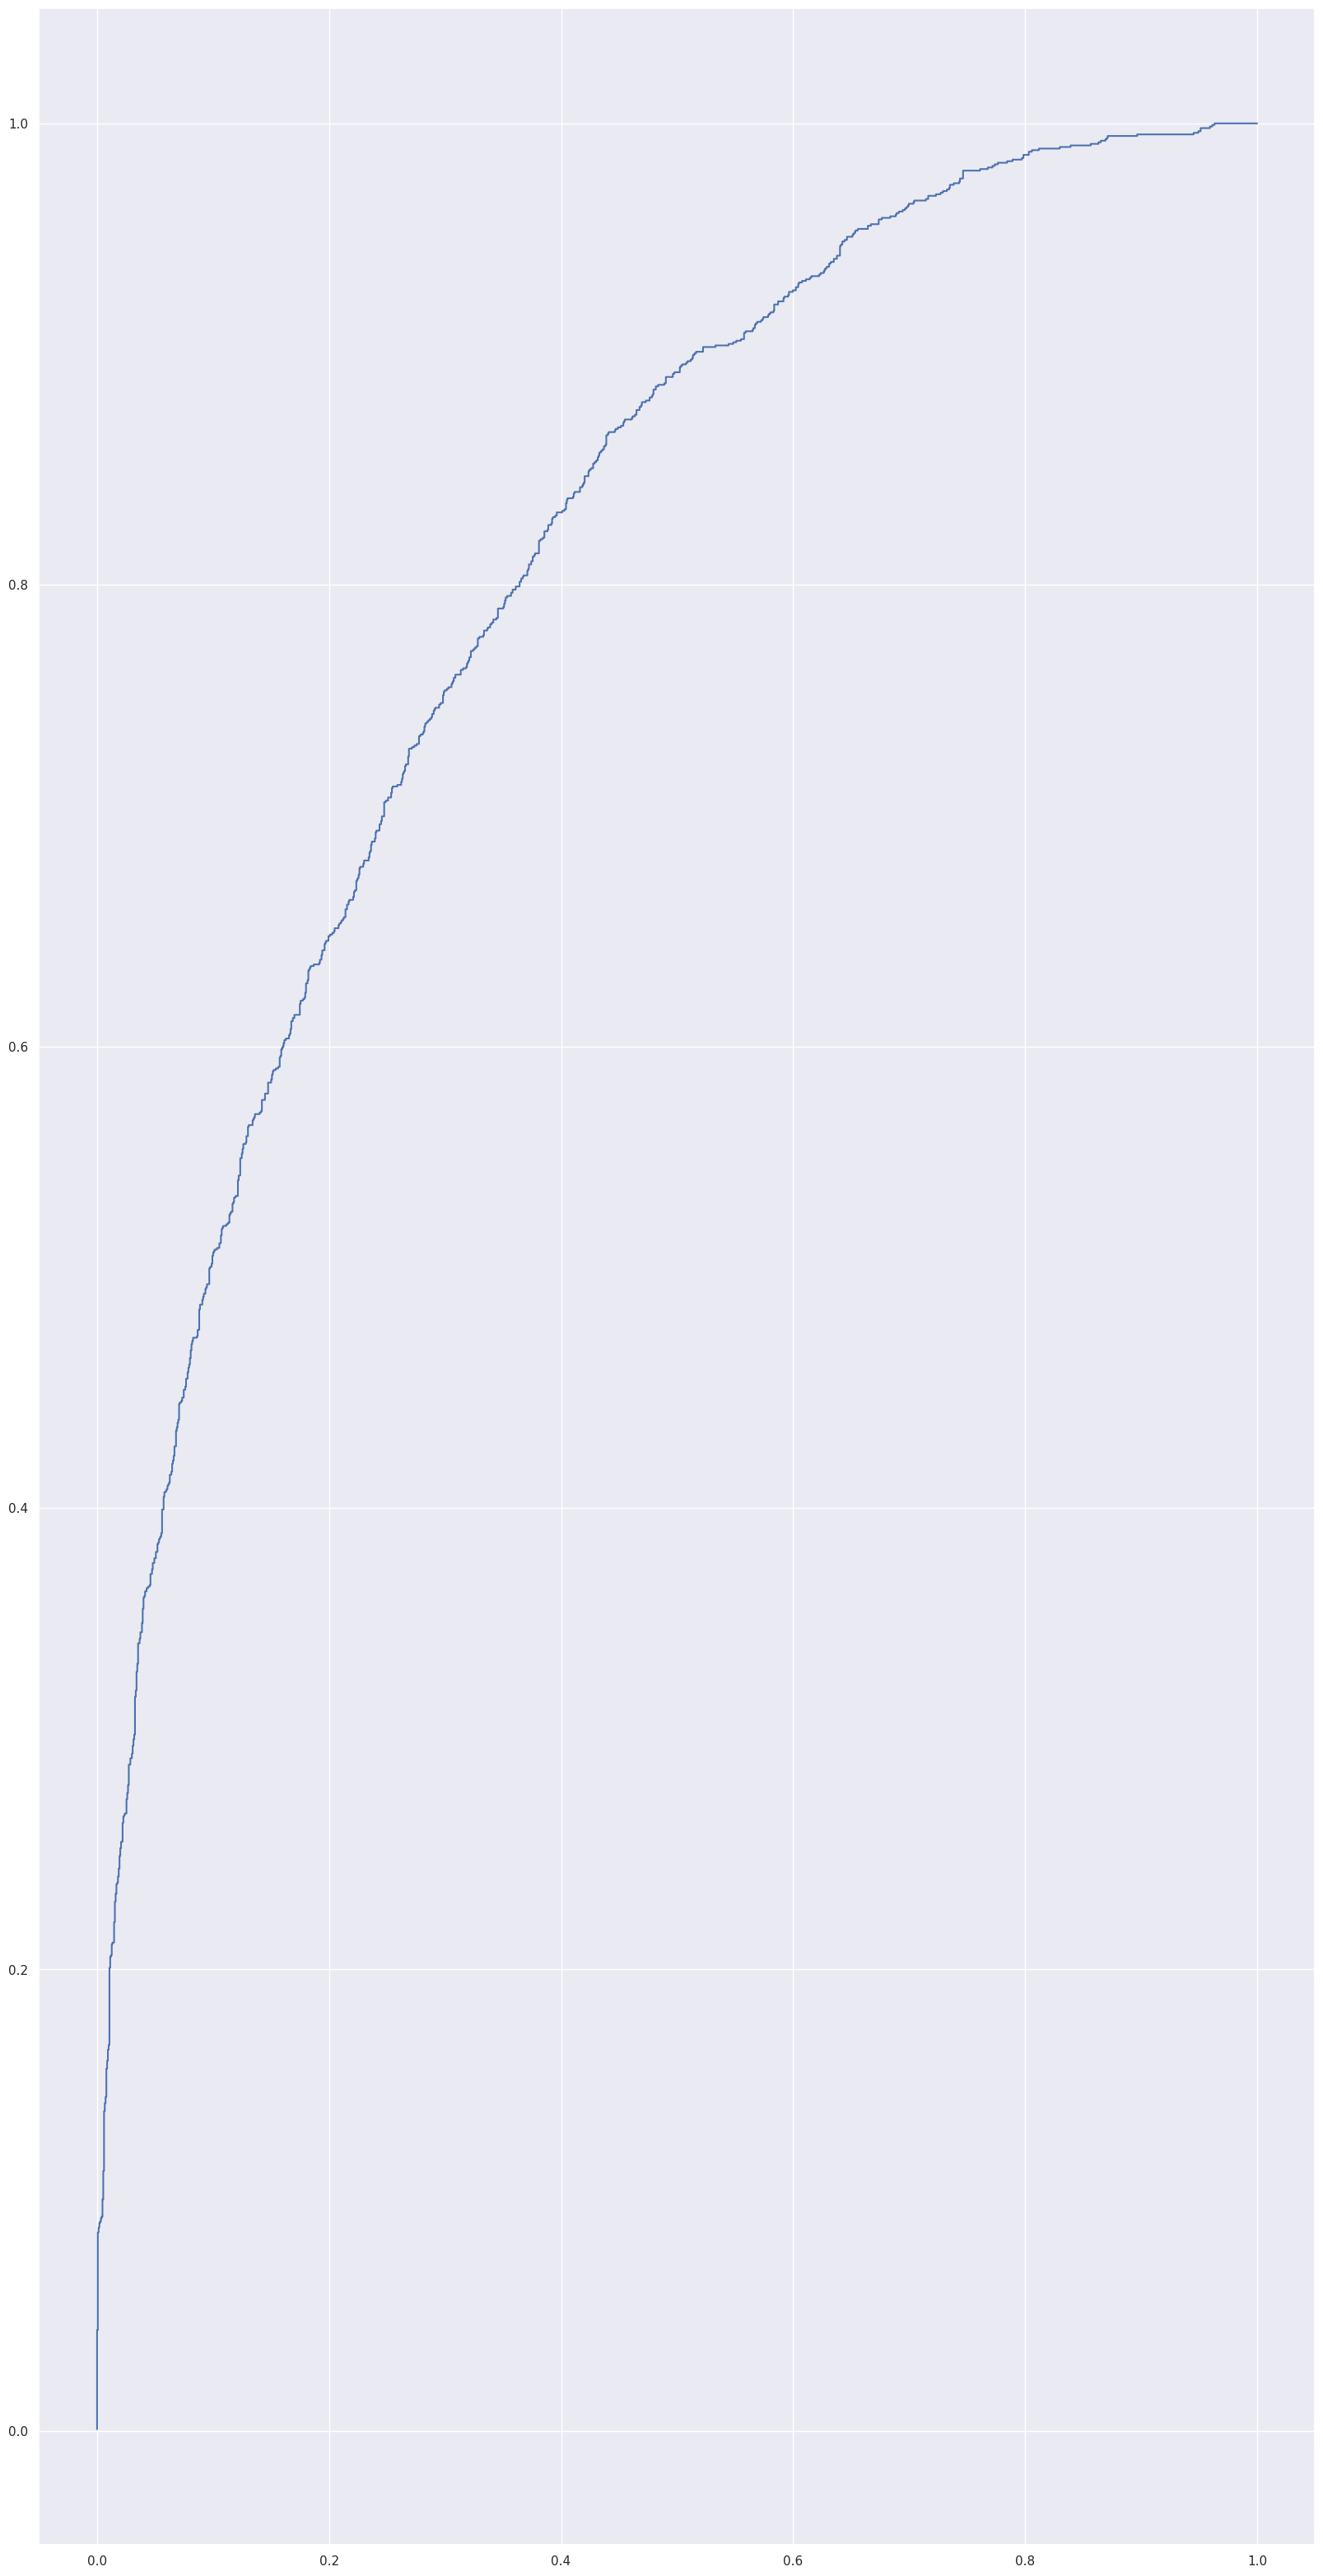

In [ ]:
y_probs_full = Logit.predict_proba(x_tst_f)
y_probs = [y_probs_full[i][1] for i in range(len(y_tst))]

In [ ]:
AUROC(y_probs, y_tst)

0.8115886131140897

In [ ]:
logit_pvalue(Logit, x_trn_f, feat)

,P-value
constant,0.7869
Dragons,0.0000
GoldDiff,0.0000
ExperienceDiff,0.0000
